In [1]:
import GetOldTweets3 as got
import numpy as np
import csv, re
from textblob import TextBlob
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from mpl_toolkits.mplot3d import Axes3D


In [2]:
""" 
### RETRIEVE TWEETS (script): 

# searchTerm = input("Enter Keywords (Space Seperated): ")
# start=input("Enter Start date in format YYYY-MM-DD: ")
# end=input("Enter End date in format YYYY-MM-DD: ")


searchTerm = "#COVID19"
start = "2020-05-10"
end = "2020-05-11"

tweetCriteria = got.manager.TweetCriteria().setQuerySearch(searchTerm)\
                                            .setSince(start)\
                                            .setUntil(end)\
                                            .setMaxTweets(50)
                                            
                                        

tweet = got.manager.TweetManager.getTweets(tweetCriteria)
 """


### RETREIVE TWEETS (Run in terminal)

#10-15th May 2020
# GetOldTweets3 --querysearch "#kitten" --since "2020-05-10" --until "2020-05-15" --toptweets --maxtweets 10000 --lang en --output "kitten10M.csv"
# GetOldTweets3 --querysearch "#pet" --since "2020-05-10" --until "2020-05-15" --toptweets --maxtweets 10000 --lang en --output "pet10M.csv"
# GetOldTweets3 --querysearch "#COVID19" --since "2020-05-10" --until "2020-05-15" --toptweets --maxtweets 10000 --lang en --output "COVID10M.csv"
# GetOldTweets3 --querysearch "#BlackLivesMatter" --since "2020-05-10" --until "2020-05-15" --toptweets --maxtweets 10000 --lang en --output "BLM10M.csv"

#26- 31 May 2020
# GetOldTweets3 --querysearch "#BlackLivesMatter" --since "2020-05-26" --until "2020-05-31" --toptweets --maxtweets 10000 --lang en --output "BLM26M.csv"
# GetOldTweets3 --querysearch "#kitten" --since "2020-05-26" --until "2020-05-31" --toptweets --maxtweets 10000 --lang en --output "kitten26M.csv"
# GetOldTweets3 --querysearch "#pet" --since "2020-05-26" --until "2020-05-31" --toptweets --maxtweets 10000 --lang en --output "pet26M.csv" 
# GetOldTweets3 --querysearch "#COVID19" --since "2020-05-26" --until "2020-05-31" --toptweets --maxtweets 10000 --lang en --output "COVID26M.csv" 


' \n### RETRIEVE TWEETS (script): \n\n# searchTerm = input("Enter Keywords (Space Seperated): ")\n# start=input("Enter Start date in format YYYY-MM-DD: ")\n# end=input("Enter End date in format YYYY-MM-DD: ")\n\n\nsearchTerm = "#COVID19"\nstart = "2020-05-10"\nend = "2020-05-11"\n\ntweetCriteria = got.manager.TweetCriteria().setQuerySearch(searchTerm)                                            .setSince(start)                                            .setUntil(end)                                            .setMaxTweets(50)\n                                            \n                                        \n\ntweet = got.manager.TweetManager.getTweets(tweetCriteria)\n '

In [3]:

# Replace the elements in namefiles with the name of the CSV files to load.
# (All files must be located in the same folder as the python script) 

namefiles = ['BLM10M','BLM26M','COVID10M','COVID26M','kitten10M','kitten26M','pet10M','pet26M']
all_data={}

for dataset in namefiles: #load all csvs

    with open(dataset + '.csv', newline='') as f:
        reader = csv.reader(f)
        list_reader =list(reader)
        all_data[dataset]= list_reader #all files are stored as a list in the all_data dictionary. 



In [4]:
# Remove errors in samples loaded. It checks that the date of the tweet is 
# May 2020, the presence of the # searched in the tweet text and  checks for repeated tweets. 
# It is necessary to introduce the hashtag associated to each list in the all_data dictionary. 
# NOTE: This step will always remove at least 1 sample as it corresponds to the first row 
# from the list of each dataset, which contains the labels of the columns. 

all_data_removed= {}
filtered_data = {}
hashtag= ['#BlackLivesMatter','#BlackLivesMatter','#COVID19','#COVID19','#kitten','#kitten','#pet','#pet'] # List of hashtags used in each dataset
length_datasets =[]

for i, datas in enumerate(all_data):
    # Select data to filter
    prep_data= pd.DataFrame(all_data[datas])

    # Check data is in may of 2020
    may_check= prep_data[0].str.contains('2020-05') #check data in May 2020 
    filtered_data[datas] = prep_data[may_check] # store filtered dataset
    removed_data = prep_data[~may_check] # store samples removed

    # Check data contains the # of interest
    hashtag_check = filtered_data[datas][6].str.contains(hashtag[i], flags = re.IGNORECASE) #check that data contains # CASE INSENSITIVE
    filtered_data [datas] = filtered_data[datas][hashtag_check]
    removed_data.append(filtered_data[datas][~hashtag_check])

    #Check repeated tweets (using URL): 
    equal_check = filtered_data[datas][11].duplicated()
    filtered_data[datas] = filtered_data[datas][~equal_check]
    removed_data.append (filtered_data[datas][equal_check])
    all_data_removed [datas] = removed_data 

    #Display info on samples removed 
    count_removed = len(removed_data) 
    print('Original size of data ' + datas +': ' + str(len(prep_data)))
    print('New size of data ' + datas + ': ' + str(len(filtered_data[datas]))) 



Original size of data BLM10M: 313
New size of data BLM10M: 303
Original size of data BLM26M: 10001
New size of data BLM26M: 9966
Original size of data COVID10M: 10001
New size of data COVID10M: 10000
Original size of data COVID26M: 10001
New size of data COVID26M: 10000
Original size of data kitten10M: 163
New size of data kitten10M: 159
Original size of data kitten26M: 186
New size of data kitten26M: 179
Original size of data pet10M: 213
New size of data pet10M: 212
Original size of data pet26M: 220
New size of data pet26M: 219


In [5]:
analyzer = SentimentIntensityAnalyzer()

scores_all = {}
for i, datas in enumerate (filtered_data): #For each dataset
    selected = filtered_data[datas]
    scores = []
    row_names = selected.index.values
    for ind, sentence in enumerate(selected[6]): #Check each sentence 
        vs = analyzer.polarity_scores(sentence)
        scores.append([sentence, selected[3][row_names[ind]], selected[4][row_names[ind]], selected[5][row_names[ind]], vs['neg'], vs['neu'], vs['pos'], vs['compound']])

    #Save scores, text and then 
    scores_all [datas] = pd.DataFrame(scores, columns= ['Text','reply','rts','fav','neg','neu','pos','compound'])

print('Sentiment analysis completed.')


Sentiment analysis completed.


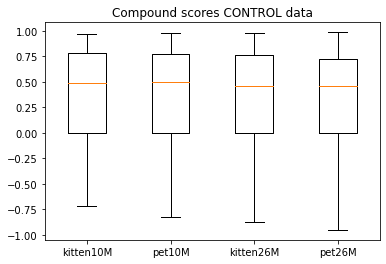

In [6]:
control_keys = ['kitten10M','pet10M','kitten26M','pet26M']
compound_control=[]
for val in control_keys:
    compound_control.append(scores_all[val]['compound'])

# Check if controls are equal. 
fig, ax= plt.subplots()
plt.boxplot(compound_control,labels=control_keys)
plt.title('Compound scores CONTROL data')
plt.show()


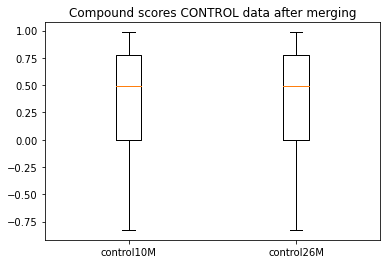

In [7]:
scores_all['control10M'] =  pd.concat([scores_all['kitten10M'], scores_all['pet10M']], ignore_index=True)
scores_all['control26M'] =  pd.concat([scores_all['kitten26M'], scores_all['pet26M']], ignore_index=True)

# Delete old keys (now merged in control 10M and control26M)
del scores_all['kitten10M'], scores_all['kitten26M'], scores_all['pet10M'], scores_all['pet26M']

# Plot 
fig, ax= plt.subplots()
plt.boxplot([scores_all['control10M']['compound'], scores_all['control10M']['compound']],labels=['control10M','control26M'])
plt.title('Compound scores CONTROL data after merging')
plt.show()



In [8]:
# NOTE: REMOVE RANDOM STATE BEFORE RUNNING!!!!! Sets a constant seed. 
# It also changes the type of the variables reply,rts and fav to numeric
length_datasets =[]
for data in scores_all
    length_datasets.append(len(scores_all[datas])) # Store sample size of each dataset 

min_sample = min(length_datasets)
sampled_data={}

for data in scores_all:  
    sampled_data[data] =  scores_all[data].sample(min_sample,random_state=1) #scores_all[data].sample(min_sample)
    sampled_data[data]['reply'] = pd.to_numeric(sampled_data[data]['reply'])
    sampled_data[data]['rts'] = pd.to_numeric(sampled_data[data]['rts'])
    sampled_data[data]['fav'] = pd.to_numeric(sampled_data[data]['fav'])
print('Sampling completed.')


SyntaxError: invalid syntax (<ipython-input-8-74223c508dc3>, line 4)

In [9]:
breakpoint()
# NOTE: REMOVE RANDOM STATE BEFORE RUNNING!!!!! Sets a constant seed. 
# It also changes the type of the variables reply,rts and fav to numeric
length_datasets =[]
for data in scores_all:
    length_datasets.append(len(scores_all[datas])) # Store sample size of each dataset 

min_sample = min(length_datasets)
sampled_data={}

for data in scores_all:  
    sampled_data[data] =  scores_all[data].sample(min_sample,random_state=1) #scores_all[data].sample(min_sample)
    sampled_data[data]['reply'] = pd.to_numeric(sampled_data[data]['reply'])
    sampled_data[data]['rts'] = pd.to_numeric(sampled_data[data]['rts'])
    sampled_data[data]['fav'] = pd.to_numeric(sampled_data[data]['fav'])
print('Sampling completed.')


KeyError: 'pet26M'

In [10]:
breakpoint()
# NOTE: REMOVE RANDOM STATE BEFORE RUNNING!!!!! Sets a constant seed. 
# It also changes the type of the variables reply,rts and fav to numeric
length_datasets =[]
for datas in scores_all:
    length_datasets.append(len(scores_all[datas])) # Store sample size of each dataset 

min_sample = min(length_datasets)
sampled_data={}

for data in scores_all:  
    sampled_data[data] =  scores_all[data].sample(min_sample,random_state=1) #scores_all[data].sample(min_sample)
    sampled_data[data]['reply'] = pd.to_numeric(sampled_data[data]['reply'])
    sampled_data[data]['rts'] = pd.to_numeric(sampled_data[data]['rts'])
    sampled_data[data]['fav'] = pd.to_numeric(sampled_data[data]['fav'])
print('Sampling completed.')


Sampling completed.


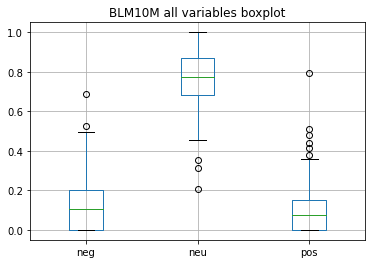

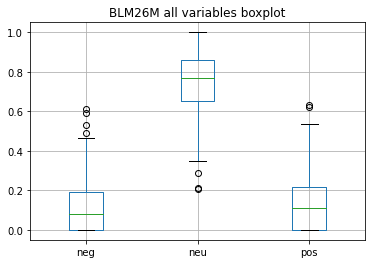

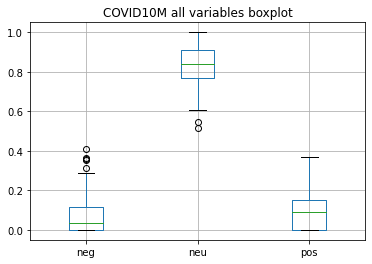

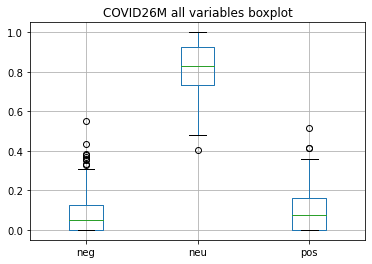

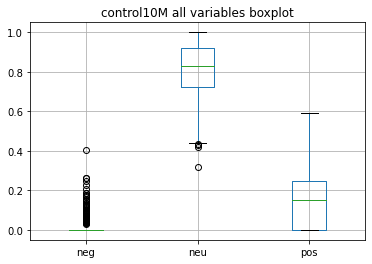

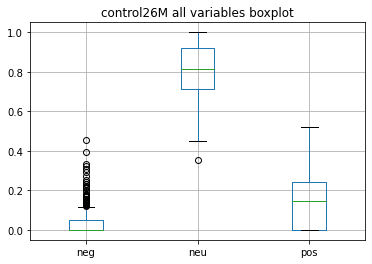

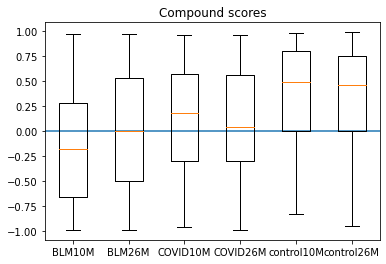

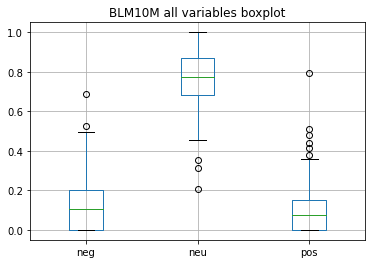

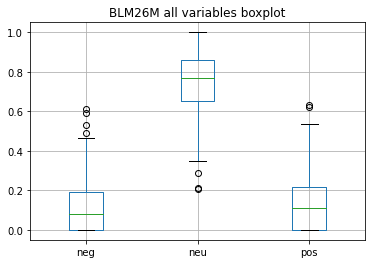

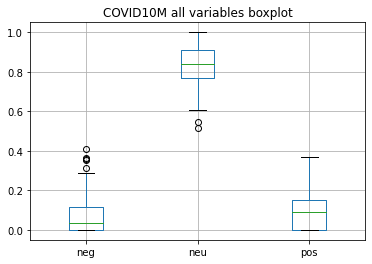

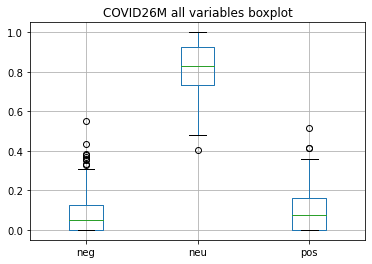

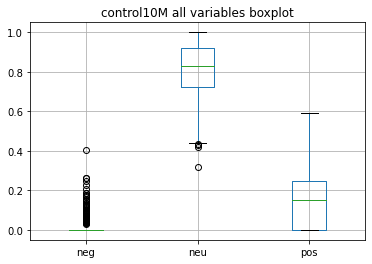

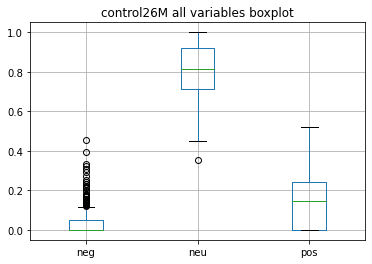

In [11]:

save_comp = []
#Plot each sampled datset:neg, neu, pos
for data in sampled_data:   
    plt.figure()
    figs = sampled_data[data].boxplot(column= ['neg','neu','pos'])
    save_comp.append(sampled_data[data]['compound'])
    plt.title(data + ' all variables boxplot')
    plt.show()

#Plot compound 
fig, ax= plt.subplots()
ax.axhline(y=0)
plt.boxplot(save_comp ,labels= sampled_data.keys())
plt.title('Compound scores')
plt.show()


for data in sampled_data:   
    plt.figure()
    figs = sampled_data[data].boxplot(column= ['neg','neu','pos'])
    save_comp.append(sampled_data[data]['compound'])
    plt.title(data + ' all variables boxplot')
    plt.show()


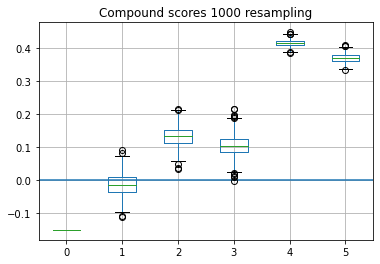

In [12]:
sampled_data={}

av_repeated = {}
for resamp in range (1000):
    save_comp_mean=[]
    for data in scores_all:   
        sampled_data[data] =  scores_all[data].sample(min_sample) #random_state=1
        sampled_data[data]['reply'] = pd.to_numeric(sampled_data[data]['reply'])
        sampled_data[data]['rts'] = pd.to_numeric(sampled_data[data]['rts'])
        sampled_data[data]['fav'] = pd.to_numeric(sampled_data[data]['fav'])
        save_comp_mean.append(np.mean(sampled_data[data]['compound']))
    av_repeated[resamp]= save_comp_mean

av_repeated2=pd.DataFrame(av_repeated).transpose()
fig, ax= plt.subplots()
ax.axhline(y=0)
av_repeated2.boxplot()
plt.title('Compound scores 1000 resampling')
plt.show()

c=1

In [13]:
num_resamp= 10000 

sampled_data={}
av_repeated = {}
for resamp in range (num_resamp):
    save_comp_mean=[]
    for data in scores_all:   
        sampled_data[data] =  scores_all[data].sample(min_sample) #random_state=1
        sampled_data[data]['reply'] = pd.to_numeric(sampled_data[data]['reply'])
        sampled_data[data]['rts'] = pd.to_numeric(sampled_data[data]['rts'])
        sampled_data[data]['fav'] = pd.to_numeric(sampled_data[data]['fav'])
        save_comp_mean.append(np.mean(sampled_data[data]['compound']))
    av_repeated[resamp]= save_comp_mean

av_repeated2=pd.DataFrame(av_repeated).transpose()
fig, ax= plt.subplots()
ax.axhline(y=0)
av_repeated2.boxplot()
plt.title(['Compound scores ' + str(num_resamp) ' resampling'])
plt.show()

c=1

SyntaxError: invalid syntax (<ipython-input-13-5b27c75744e1>, line 19)

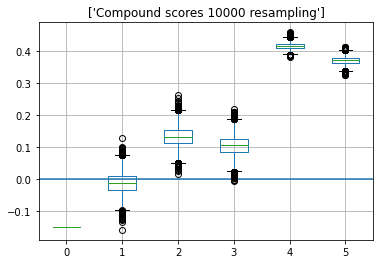

In [14]:
num_resamp= 10000 

sampled_data={}
av_repeated = {}
for resamp in range (num_resamp):
    save_comp_mean=[]
    for data in scores_all:   
        sampled_data[data] =  scores_all[data].sample(min_sample) #random_state=1
        sampled_data[data]['reply'] = pd.to_numeric(sampled_data[data]['reply'])
        sampled_data[data]['rts'] = pd.to_numeric(sampled_data[data]['rts'])
        sampled_data[data]['fav'] = pd.to_numeric(sampled_data[data]['fav'])
        save_comp_mean.append(np.mean(sampled_data[data]['compound']))
    av_repeated[resamp]= save_comp_mean

av_repeated2=pd.DataFrame(av_repeated).transpose()
fig, ax= plt.subplots()
ax.axhline(y=0)
av_repeated2.boxplot()
plt.title(['Compound scores ' + str(num_resamp) + ' resampling'])
plt.show()

c=1